## Explore AF kinases with multiple models

Some kinases have multiple models in the human proteome download archive (F1, F2, ... instead of only F1).

Turns out these kinases have a length above the AF cutoff described in the AlphaFold DB paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from pathlib import Path
from tempfile import NamedTemporaryFile
import os

import requests
import pandas as pd
from Bio import SeqIO

In [3]:
# Set path to this notebook
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data"

In [4]:
# Path to AF download
AF_PATH = Path(DATA / "external/structures/AlphaFoldDB")
# Path to folder for processed output files from this notebook
AF_KLIFS_METADATA_PATH = DATA / "processed/af_klifs_metadata.csv"
SEQUENCES_PATH = AF_PATH / "sequences.fasta"

## Load kinases (AF/KLIFS)

In [5]:
af_kinases = pd.read_csv(AF_KLIFS_METADATA_PATH)
af_kinases["structure.af_name"] = af_kinases["structure.af_file"].str.split("-model")
af_kinases["structure.af_name"] = af_kinases["structure.af_name"].apply(lambda x: x[0])
af_kinases

,kinase.uniprot,structure.af_file,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,species.klifs,n_models,structure.af_name
0,Q2M2I8,AF-Q2M2I8-F1-model_v1.pdb.gz,277,AAK1,AP2 associated kinase 1,AAK1,Human,1,AF-Q2M2I8-F1
1,Q6ZMQ8,AF-Q6ZMQ8-F1-model_v1.pdb.gz,443,LMR1,apoptosis-associated tyrosine kinase,AATK,Human,1,AF-Q6ZMQ8-F1
2,P00519,AF-P00519-F1-model_v1.pdb.gz,392,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",ABL1,Human,1,AF-P00519-F1
3,P42684,AF-P42684-F1-model_v1.pdb.gz,393,ABL2,"ABL proto-oncogene 2, non-receptor tyrosine ki...",ABL2,Human,1,AF-P42684-F1
4,Q04771,AF-Q04771-F1-model_v1.pdb.gz,516,ALK2,activin A receptor type I,ACVR1,Human,1,AF-Q04771-F1
...,...,...,...,...,...,...,...,...,...
550,Q9Y3S1,AF-Q9Y3S1-F1-model_v1.pdb.gz,339,Wnk2,WNK lysine deficient protein kinase 2,WNK2,Human,1,AF-Q9Y3S1-F1
551,Q9BYP7,AF-Q9BYP7-F1-model_v1.pdb.gz,338,Wnk3,WNK lysine deficient protein kinase 3,WNK3,Human,1,AF-Q9BYP7-F1
552,Q96J92,AF-Q96J92-F1-model_v1.pdb.gz,337,Wnk4,WNK lysine deficient protein kinase 4,WNK4,Human,1,AF-Q96J92-F1
553,P07947,AF-P07947-F1-model_v1.pdb.gz,463,YES,"YES proto-oncogene 1, Src family tyrosine kinase",YES1,Human,1,AF-P07947-F1


## Load kinase sequences (AF/UniProt)

In [6]:
# Try out SeqIO module
for record in SeqIO.parse(SEQUENCES_PATH, "fasta"):
    if "AF-Q54E14-F1" in record.id:
        print(record.id)
        print(record.id[5:])
        print(record.description)
        print(record.seq)
        print(len(record.seq))

AFDB:AF-Q54E14-F1
AF-Q54E14-F1
AFDB:AF-Q54E14-F1 Uncharacterized protein
MADDHSTELQLNHTDNNTTNTNNTSTTSTTKNKSAKIDTPKKQTPTNQLSLNKGLDNQLDIIAPPSITRPLSFLEKKQ
78


In [7]:
%%time
kinase_sequences = []
for record in SeqIO.parse(SEQUENCES_PATH, "fasta"):
    if record.id.split("-")[1] in af_kinases["kinase.uniprot"].to_list():
        kinase_sequences.append([record.id, str(record.seq)])
kinase_sequences = pd.DataFrame(kinase_sequences, columns=["af.id", "uniprot.sequence"])

CPU times: user 5.75 s, sys: 33.3 ms, total: 5.79 s
Wall time: 5.77 s


In [8]:
kinase_sequences["uniprot.id"] = kinase_sequences["af.id"].str.split("-") 
uniprot_ids = kinase_sequences["uniprot.id"].apply(lambda x: x[1])
af_models = kinase_sequences["uniprot.id"].apply(lambda x: x[2])
kinase_sequences["uniprot.id"] = uniprot_ids
kinase_sequences["af.model"] = af_models
kinase_sequences["uniprot.sequence_length"] = kinase_sequences["uniprot.sequence"].apply(len)
kinase_sequences = kinase_sequences.sort_values("uniprot.sequence_length", ascending=False)

### Are models > F1 included in sequence file? No.

In [9]:
kinase_sequences["af.model"].unique()

array(['F1'], dtype=object)

<AxesSubplot:ylabel='Frequency'>

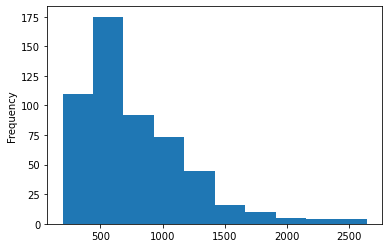

In [16]:
kinase_sequences["uniprot.sequence_length"].plot(kind="hist")

> We predicted structures for the UniProt human reference proteome (one representative sequence per gene), with an upper length limit of 2700 residues.

From AlphaFold DB paper: https://www.nature.com/articles/s41586-021-03828-1

## Get sequence length for UniProt IDs with multiple models

In [10]:
af_kinases = pd.merge(
    af_kinases.rename(columns={"kinase.uniprot": "uniprot.id"}), 
    kinase_sequences, 
    on="uniprot.id", 
    how="left"
)
af_kinases = af_kinases[["uniprot.id", "uniprot.sequence_length", "n_models"]].sort_values("n_models", ascending=False)

Now match AF structures with multiple models and their sequence length!

In [29]:
af_kinases_multiple_modules = af_kinases[af_kinases["n_models"] > 1].copy()
af_kinases_multiple_modules

,uniprot.id,uniprot.sequence_length,n_models
534,Q8WZ42,NaN,166
322,Q5VST9,NaN,34
321,Q5VST9,NaN,34
525,Q9Y4A5,NaN,14
458,Q96Q15,NaN,13
460,Q15772,NaN,11
461,Q15772,NaN,11
522,O75962,NaN,10
24,Q13315,NaN,10
207,O60229,NaN,9


All proteins with > 2700 residues (AF cutoff, thus not included in their sequence file, thus `NaN`) contain multiple models. Get their sequence length from UniProt directly.

In [21]:
def sequence_for_uniprot_id(uniprot_id):
    """
    Returns the FASTA sequence of a given Uniprot ID using
    the UniProt URL-based API

    Parameters
    ----------
    uniprot_id : str

    Returns
    -------
    Bio.SeqIO.SeqRecord
    """
    #                                                  ⬇ this is key part!
    r = requests.get(f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta")
    r.raise_for_status()

    with NamedTemporaryFile(suffix=".fasta", mode="w", delete=False) as tmp:
        tmp.write(r.text)

    sequence = SeqIO.read(tmp.name, format="fasta")
    os.remove(tmp.name)

    return sequence

In [30]:
af_kinases_multiple_modules["uniprot.sequence_length"] = af_kinases_multiple_modules["uniprot.id"].apply(
    lambda x: len(sequence_for_uniprot_id(x))
)
af_kinases_multiple_modules

,uniprot.id,uniprot.sequence_length,n_models
534,Q8WZ42,34350,166
322,Q5VST9,7968,34
321,Q5VST9,7968,34
525,Q9Y4A5,3859,14
458,Q96Q15,3661,13
460,Q15772,3267,11
461,Q15772,3267,11
522,O75962,3097,10
24,Q13315,3056,10
207,O60229,2986,9


Conclusion: All kinase with multiple models are kinases with >2700 residues (AF cutoff). 